In [2]:
import numpy as np
import astropy.io.fits as pf
%matplotlib inline
import matplotlib.pyplot as plt
from sympy import *
from matplotlib.ticker import PercentFormatter
import pickle
import random
import os


import sys
sys.path.insert(0, '/Users/arielamsellem/Desktop/Research/py_scripts/current_py_scripts/')
from SPT_functions import *

In [3]:
# Construct Galaxy Cluster Classes
class ACT_cluster:
    def __init__(self, ra, dec, z, dz, lam, dlam, m, m_uperr, m_loerr):
        self.ra            = ra
        self.dec           = dec
        self.z             = z
        self.dz            = dz
        self.lam           = lam
        self.dlam          = dlam
        self.m             = m
        self.m_uperr       = m_uperr
        self.m_loerr       = m_loerr
        self.match_id      = None
        self.arcmin_diff   = None
        self.z_diff        = None
        self.lam_diff      = None
        self.m_diff        = None
        self.sigmaz        = None
        self.min_num       = 1

class RM_cluster:
    def __init__(self, ra, dec, z, dz, lam, dlam, ids, R):
        self.ra          = ra
        self.dec         = dec
        self.z           = z
        self.dz          = dz
        self.lam         = lam
        self.dlam        = dlam
        self.ids         = ids
        self.R           = R
        self.match       = 0.
        self.arcmin_diff = None
        self.z_diff      = None
        self.lam_diff    = None
        self.m_diff      = None
        self.sigmaz      = None
        
        m, dm  = convert_rich_to_mass_CH(lam, dlam)
        self.m  = m
        self.dm = dm

## Data

In [4]:
# Import ACT telescope Data
ACT    = pf.open('/Users/arielamsellem/Desktop/Research/Y3-Buzzard_1.9.8/Plots/ACT_data_files/AdvACT_S18Clusters_v1.0-beta_DESY3Only.fits')[1].data
z_a    = ACT['redshift']
in_RM  = ACT['RMDESY3']
mask_a = (z_a>0.25)*(z_a<0.7)*(in_RM==True)

z_a       = ACT['redshift'][mask_a]
dz_a      = ACT['redshiftErr'][mask_a]
lam_a     = ACT['RMDESY3_LAMBDA_CHISQ'][mask_a]
dlam_a    = ACT['RMDESY3_LAMBDA_CHISQ_E'][mask_a]
m_a       = ACT['M200m'][mask_a]
m_uperr_a = ACT['M200m_errPlus'][mask_a]
m_loerr_a = ACT['M200m_errMinus'][mask_a]
ra_a      = ACT['RAdeg'][mask_a]
dec_a     = ACT['decDEG'][mask_a]
print(len(dec_a))

# Redmapper DES Y3 telescope Data
Y3_dat = '/Users/arielamsellem/Desktop/Research/Y3-Buzzard_1.9.8/Plots/SPT_data_files/y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt5_vl02_catalog.fit'
Y3 = pf.open(Y3_dat)[1].data
z_3   = Y3['Z_LAMBDA']
lam_3  = Y3['lambda_chisq']
mask_3 = (z_3>0.25)*(z_3<0.7)*(lam_3>20.)

ra_3   = Y3['ra'][mask_3]
dec_3  = Y3['dec'][mask_3]
z_3    = Y3['Z_LAMBDA'][mask_3]
dz_3   = Y3['Z_LAMBDA_E'][mask_3]
lam_3  = Y3['lambda_chisq'][mask_3]
dlam_3 = Y3['LAMBDA_CHISQ_E'][mask_3]
ids_3  = Y3['MEM_MATCH_ID'][mask_3]
R_3    = Y3['R_LAMBDA'][mask_3]
print(len(dec_3))

# Sigmaz column for Redmapper Clusters
sigz_dat = '/Users/arielamsellem/Desktop/Research/Y3-Buzzard_1.9.8/Plots/SPT_data_files/sigma_zmeasurement_desy3_lgt15.fits'


1001
18146


In [6]:
# Make list of ACT cluster class objects
clus_a = []
for j, val in enumerate(ra_a):
    x = ACT_cluster(ra_a[j], dec_a[j], z_a[j], dz_a[j], lam_a[j], dlam_a[j], m_a[j], m_uperr_a[j], m_loerr_a[j])
    clus_a.append(x)
clus_a = np.array(clus_a)

# Make list of RM cluster class objects
clus_r = []
for j, val in enumerate(ra_3):
    x = RM_cluster(ra_3[j], dec_3[j], z_3[j], dz_3[j], lam_3[j], dlam_3[j], ids_3[j], R_3[j])
    clus_r.append(x)
clus_r = np.array(clus_r)

In [7]:
# Make list of ACT and RM masses
mr = []
ma = []    
for clus in clus_r:
    mr.append(clus.m)
for clus in clus_a:
    ma.append(clus.m)

In [9]:
# Initialize binned grids (ACT and RM) in lambda (number of galaxies in galaxy cluster) and redshift 
z_bins = 5
lam_bins = 24
ACT_arr = np.zeros((z_bins, lam_bins), dtype = object)
RM_arr  = np.zeros((z_bins, lam_bins), dtype = object)
RM_sel_counts_arr  = np.zeros((z_bins, lam_bins), dtype = object)
z_space   = 0.01*np.linspace(25., 61., z_bins)
lam_space = np.linspace(1., 24., lam_bins)

for i in range(0,z_bins):
    for j in range(0,lam_bins):
        ACT_arr[i,j] = []
        RM_arr[i,j]  = []
        
# Populate the grids with clusters
for i, zval in enumerate(z_space):
    for j, mval in enumerate(lam_space):
        for clus in clus_a:
            if (clus.m >= mval) & (clus.m < mval + 1.) & (clus.z >= zval) & (clus.z < zval + 0.09):
                ACT_arr[i,j].append(clus)
        for clus in clus_r:
            if (clus.m >= mval) & (clus.m < mval + 1.) & (clus.z >= zval) & (clus.z < zval + 0.09):
                RM_arr[i,j].append(clus)

# Print counts in each bin of each grid
ACT_counts_arr = ACT_arr.copy()
RM_counts_arr  = RM_arr.copy()

for i, zval in enumerate(z_space):
    for j, mval in enumerate(lam_space):
        new_val = len(ACT_arr[i,j])
        ACT_counts_arr[i,j] = new_val
for i, zval in enumerate(z_space):
    for j, mval in enumerate(lam_space):
        new_val = len(RM_arr[i,j])
        RM_counts_arr[i,j] = new_val
print(ACT_counts_arr)
print()
print(RM_counts_arr)

[[0 19 55 53 20 11 8 1 0 2 3 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 17 69 77 21 9 12 7 3 3 3 0 4 0 0 0 0 0 0 0 0 0 0 1]
 [0 17 58 73 26 6 10 4 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 10 81 59 23 12 8 4 4 4 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 23 68 50 32 13 5 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

[[1026 958 323 171 68 37 18 13 7 6 2 1 2 3 0 0 1 1 0 0 0 0 0 0]
 [1566 1369 454 196 104 44 23 16 6 6 7 3 1 2 2 1 0 0 1 0 0 0 0 0]
 [1754 1437 465 184 87 33 19 14 5 6 3 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [2020 1665 477 194 69 42 23 9 7 5 5 3 1 0 0 0 1 0 0 0 0 0 0 0]
 [1457 1140 343 128 60 20 18 5 3 1 2 1 0 1 0 0 0 0 0 0 0 0 0 0]]


In [10]:
# Randomly select clusters from the grids so that the ACT and RM lambda distributions are similar
ACT_sel  = []
RM_sel   = []
RM_factor = 5.
for i in range(0,z_bins):
    for j in range(0,lam_bins):
        for num_selected in np.flip(np.linspace(1,65,65)):
            if (len(ACT_arr[i,j]) >= num_selected) & (len(RM_arr[i,j]) >= RM_factor*num_selected):
                random.seed(1)
                selected_clusters_A = random.sample(ACT_arr[i,j], int(num_selected))
                random.seed(2)
                selected_clusters_R = random.sample(RM_arr[i,j], int(RM_factor*num_selected))
                ACT_sel.extend(selected_clusters_A)
                RM_sel.extend(selected_clusters_R)
                RM_sel_counts_arr[i,j] = RM_factor*num_selected
                break

In [12]:
# Compile a list of lambda values from the list of RM and ACT clusters
m_am = []
m_3m = []
m_h  = []
for clus in RM_sel:
    m_3m.append(clus.m)
for clus in ACT_sel:
    m_am.append(clus.m)
for halo in halos_sel:
    m_h.append(halo.mass/10**14)

In [13]:
# Print the number of ACT and RM clusters
print("Number of ACT clusters: " + str(len(ACT_sel)))
print("Number of RM clusters:  " + str(len(RM_sel)))
print("Number of halos:        " + str(len(halos_sel)))

Number of ACT clusters: 707
Number of RM clusters:  3535
Number of halos:        3535


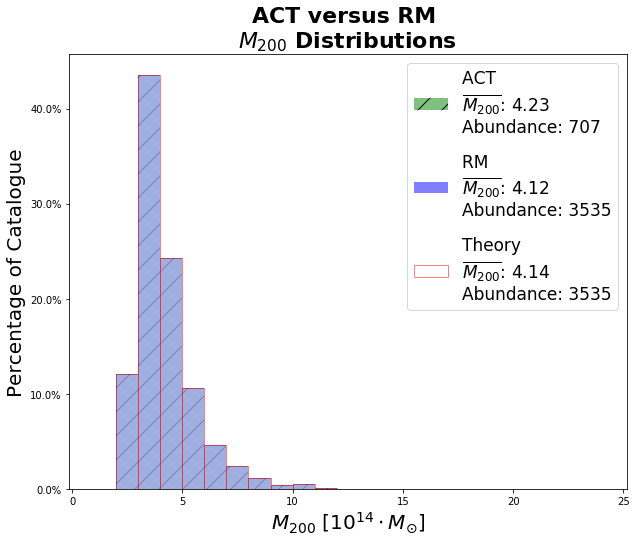

In [17]:
# Show lambda distribution of the ACT and RM clusters to check if they are similar enough
fig, ax1 = plt.subplots(figsize=(10,8))

bins1 = lam_space
ax1.hist(m_am, bins=bins1,color = 'green', weights=np.ones(len(m_am))/len(m_am), 
         hatch='/', fill=True, alpha = 0.5, 
         label = 'ACT \n$\\overline{M_{200}}$: %.2f\nAbundance: %.0f' % (np.mean(m_am), len(m_am)))
ax1.hist(m_3m, bins=bins1,color = 'blue', weights=np.ones(len(m_3m))/len(m_3m),
         fill=True, alpha = 0.5, 
         label = 'RM \n$\\overline{M_{200}}$: %.2f\nAbundance: %.0f' % (np.mean(m_3m), len(m_3m)))
ax1.hist(m_h, bins=bins1,color = 'white', weights=np.ones(len(m_h))/len(m_h),
         edgecolor='red', fill=True, alpha = 0.5, 
         label = 'Theory \n$\\overline{M_{200}}$: %.2f\nAbundance: %.0f' % (np.mean(m_h), len(m_h)))

ax1.set_xlabel('$M_{200}$ [$10^{14} \cdot M_{\\odot}$]', fontsize = 20.)
ax1.set_ylabel('Percentage of Catalogue', fontsize = 20.)
ax1.set_title('ACT versus RM \n$M_{200}$ Distributions', fontsize = 22, fontweight=900)
ax1.legend(fontsize = 17, labelspacing = 1)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('/Users/arielamsellem/Desktop/ACT_and_RM_Mass_Distribution_mass-match', dpi = 600)
plt.show()

In [12]:
# Match all the ACT clusters to a RM cluster
ra_3   = []
dec_3  = []
z_3    = []
dz_3   = []
m_3  = []
dm_3 = []
ids_3  = []
for clus in RM_sel:
    ra_3.append(clus.ra)
    dec_3.append(clus.dec)
    z_3.append(clus.z)
    dz_3.append(clus.dz)
    m_3.append(clus.m)
    dm_3.append(clus.dm)
    ids_3.append(clus.ids)
ra_3   = np.array(ra_3)
dec_3  = np.array(dec_3)
z_3    = np.array(z_3)
dz_3   = np.array(dz_3)
m_3  = np.array(m_3)
dm_3 = np.array(dm_3)
ids_3  = np.array(ids_3)

dat_3  = np.array(list(zip(ra_3, dec_3, z_3, dz_3, m_3, dm_3, ids_3)))

id_already = []
A_cluster_already = []
for i, A_cluster in enumerate(ACT_sel):
    # Find the angular separation, redshift difference, and mass difference between the all RM clusters and the ACT cluster
    sep    = find_sep(dat_3[:,0], dat_3[:,1], A_cluster.ra, A_cluster.dec)
    z_diff = np.absolute(dat_3[:,2] - A_cluster.z)
    m_diff = np.absolute(dat_3[:,4] - A_cluster.m)

    match_idx = np.where(sep == np.min(sep))[0][0]

    # Save information of the matched RM cluster on the ACT cluster object
    A_cluster.match_id    = dat_3[:,6][match_idx]
    A_cluster.arcmin_diff = sep.arcminute[match_idx]
    A_cluster.z_diff      = z_diff[match_idx]
    A_cluster.m_diff      = m_diff[match_idx]
    
    # Save the match id of the RM cluster and the ACT cluster
    id_already.append(match_idx)
    A_cluster_already.append(A_cluster)

    # When two ACT clusters match to the same RM cluster...
    while len(np.unique(id_already)) != len(id_already):
        # Find the id of the RM cluster that is matched twice
        dup_id = set([x for x in id_already if id_already.count(x) > 1]).pop()

        # Get the separation between the RM cluster and the first of the matched ACT clusters
        loc_1 = np.where(id_already == dup_id)[0][0]
        clus_1 = A_cluster_already[loc_1]
        min_sep_1 = clus_1.arcmin_diff

        # Get the separation between the RM cluster and the second of the matched ACT clusters
        loc_2 = np.where(id_already == dup_id)[0][1]
        clus_2 = A_cluster_already[loc_2]
        min_sep_2 = clus_2.arcmin_diff

        # If the second ACT cluster is farther away from the match...
        if min_sep_1 < min_sep_2:
            # Find the next closest RM cluster to match the first ACT cluster to
            seps_2     = find_sep(dat_3[:,0], dat_3[:,1], clus_2.ra, clus_2.dec)
            z_diff_2   = np.absolute(dat_3[:,2] - clus_2.z  )
            m_diff_2   = np.absolute(dat_3[:,4] - clus_2.m)
            sep_next_min_2 = np.partition(seps_2.arcminute, clus_2.min_num+1)[clus_2.min_num+1]
            match_idx_2 = np.where(seps_2.arcminute == sep_next_min_2)[0][0]
            clus_2.match_id    = dat_3[:,6][match_idx_2]
            clus_2.arcmin_diff = seps_2.arcminute[match_idx_2]
            clus_2.z_diff      = z_diff_2[match_idx_2]
            clus_2.m_diff      = m_diff_2[match_idx_2]
            clus_2.min_num    += 1
            # Remove the match info of the first ACT cluster from lists, and add the new info
            del id_already[loc_2]
            del A_cluster_already[loc_2]
            id_already.append(match_idx_2)
            A_cluster_already.append(clus_2)

        # If the first ACT cluster is farther away from the match...
        if min_sep_2 < min_sep_1:
            # Find the next closest RM cluster to match the second ACT cluster to
            seps_1   = find_sep(dat_3[:,0], dat_3[:,1], clus_1.ra, clus_1.dec)
            z_diff_1 = np.absolute(dat_3[:,2] - clus_1.z)
            m_diff_1 = np.absolute(dat_3[:,4] - clus_1.m)
            sep_next_min_1 = np.partition(seps_1.arcminute, clus_1.min_num+1)[clus_1.min_num+1]
            match_idx_1 = np.where(seps_1.arcminute == sep_next_min_1)[0][0]
            clus_1.match_id    = dat_3[:,6][match_idx_1]
            clus_1.arcmin_diff = seps_1.arcminute[match_idx_1]
            clus_1.z_diff      = z_diff_1[match_idx_1]
            clus_1.m_diff      = m_diff_1[match_idx_1]
            clus_1.min_num    += 1
            # Remove the match info of the second ACT cluster from lists, and add the new info
            del id_already[loc_1]
            del A_cluster_already[loc_1]
            id_already.append(match_idx_1)
            A_cluster_already.append(clus_1)



In [13]:
# Find RM clusters that were matched
match_ids = []
for A_cluster in ACT_sel:
    if A_cluster.match_id != None:
        match_id = A_cluster.match_id
        match_ids.append(match_id)

# Compile a list of RM cluster objects
RM_sel_m = []
for R_cluster in RM_sel:
    if R_cluster.ids in match_ids:
        R_cluster.match += 1.
        RM_sel_m.append(R_cluster)
print("Number of Matched Clusters: " + str(len(RM_sel_m)))

# Record ACT info on matched RM clusters
for R_cluster in RM_sel_m:
    for A_cluster in ACT_sel:
        if R_cluster.ids == A_cluster.match_id:
            R_cluster.arcmin_diff = A_cluster.arcmin_diff
            R_cluster.z_diff      = A_cluster.z_diff
            R_cluster.lam_diff    = A_cluster.lam_diff

Number of Matched Clusters: 707


In [14]:
# Match Sigmazs to unmatched RM clusters
RM_sel_2 = []
for R_cluster in RM_sel:
    match_sigz_class(R_cluster, sigz_dat)
    if R_cluster.sigmaz != None:
        RM_sel_2.append(R_cluster)
RM_sel = RM_sel_2
# print the number of unmatched clusters that had sigmaz values
print("Number of Unmatched Clusters (with sigmaz): " + str(len(RM_sel)))
print()

# Match Sigmazs to matched RM clusters
RM_sel_m2 = []
for R_cluster in RM_sel_m:
    match_sigz_class(R_cluster, sigz_dat)
    if R_cluster.sigmaz != None:
        RM_sel_m2.append(R_cluster)
RM_sel_m = RM_sel_m2
# print the number of matched clusters that had sigmaz values
print("Number of Matched Clusters (with sigmaz): " + str(len(RM_sel_m)))
print()

Number of Unmatched Clusters (with sigmaz): 3535

Number of Matched Clusters (with sigmaz): 707



In [15]:
clus_10 = []
zbins = np.arange(0,9)

m_count_below_0 = 0.
m_count_0 = 0.
m_count_10 = 0.
m_count_20 = 0.
m_count_30 = 0.
m_count_40 = 0.
m_count_50 = 0.
m_count_60 = 0.
m_count_70 = 0.
m_count_80 = 0.
m_count_90 = 0.
m_count_above_100 = 0.

count_below_0 = 0.
count_0 = 0.
count_10 = 0.
count_20 = 0.
count_30 = 0.
count_40 = 0.
count_50 = 0.
count_60 = 0.
count_70 = 0.
count_80 = 0.
count_90 = 0.
count_above_100 = 0.

for zbin in zbins:
    zmin = zbin*.05 + .25
    zmax = zbin*.05 + .3
    
    sigzs_m = []
    sigzs_r = []
    for clus in RM_sel:
        if ((clus.z >= zmin) and (clus.z <= zmax)):
            sigzs_r.append(clus.sigmaz)
            
    # Find sigmaz percentiles (in intervals of 10) values 
    sigmaz_0    = np.percentile(sigzs_r, 0 )
    sigmaz_10   = np.percentile(sigzs_r, 10)
    sigmaz_20   = np.percentile(sigzs_r, 20)
    sigmaz_30   = np.percentile(sigzs_r, 30)
    sigmaz_40   = np.percentile(sigzs_r, 40)
    sigmaz_50   = np.percentile(sigzs_r, 50)
    sigmaz_60   = np.percentile(sigzs_r, 60)
    sigmaz_70   = np.percentile(sigzs_r, 70)
    sigmaz_80   = np.percentile(sigzs_r, 80)
    sigmaz_90   = np.percentile(sigzs_r, 90)
    sigmaz_100  = np.percentile(sigzs_r, 100)

    
    match_10_bin = []
    tot_10_bin = []
    for clus in RM_sel_m:
        if (clus.z >= zmin) and (clus.z <= zmax):
            sig_val = clus.sigmaz 
            if (sig_val < sigmaz_0):
                m_count_below_0 += 1.
            elif (sig_val >= sigmaz_0) & (sig_val < sigmaz_10):
                m_count_0 += 1.
            elif (sig_val >= sigmaz_10) & (sig_val < sigmaz_20):
                m_count_10 += 1.
            elif (sig_val >= sigmaz_20) & (sig_val < sigmaz_30):
                m_count_20 += 1.
            elif (sig_val >= sigmaz_30) & (sig_val < sigmaz_40):
                m_count_30 += 1.
            elif (sig_val >= sigmaz_40) & (sig_val < sigmaz_50):
                m_count_40 += 1.
            elif (sig_val >= sigmaz_50) & (sig_val < sigmaz_60):
                m_count_50 += 1.
            elif (sig_val >= sigmaz_60) & (sig_val < sigmaz_70):
                m_count_60 += 1.
            elif (sig_val >= sigmaz_70) & (sig_val < sigmaz_80):
                m_count_70 += 1.
            elif (sig_val >= sigmaz_80) & (sig_val < sigmaz_90):
                m_count_80 += 1.
            elif (sig_val >= sigmaz_90) & (sig_val <= sigmaz_100):
                m_count_90 += 1.
            elif (sig_val > sigmaz_100):
                m_count_above_100 += 1.
                
 
    for clus in RM_sel:
        if (clus.z >= zmin) and (clus.z <= zmax) and (clus.sigmaz != None):
            sig_val = clus.sigmaz 
            if (sig_val < sigmaz_0):
                count_below_0 += 1.
            elif (sig_val >= sigmaz_0) & (sig_val < sigmaz_10):
                count_0 += 1.
                clus_10.append(clus)
            elif (sig_val >= sigmaz_10) & (sig_val < sigmaz_20):
                count_10 += 1.
            elif (sig_val >= sigmaz_20) & (sig_val < sigmaz_30):
                count_20 += 1.
            elif (sig_val >= sigmaz_30) & (sig_val < sigmaz_40):
                count_30 += 1.
            elif (sig_val >= sigmaz_40) & (sig_val < sigmaz_50):
                count_40 += 1.
            elif (sig_val >= sigmaz_50) & (sig_val < sigmaz_60):
                count_50 += 1.
            elif (sig_val >= sigmaz_60) & (sig_val < sigmaz_70):
                count_60 += 1.
            elif (sig_val >= sigmaz_70) & (sig_val < sigmaz_80):
                count_70 += 1.
            elif (sig_val >= sigmaz_80) & (sig_val < sigmaz_90):
                count_80 += 1.
            elif (sig_val >= sigmaz_90) & (sig_val <= sigmaz_100):
                count_90 += 1.
            elif (sig_val > sigmaz_100):
                count_above_100 += 1.
                



sigmaz_r_tiles = np.array([count_below_0, count_0, count_10, count_20, count_30, count_40, count_50, count_60, 
                           count_70, count_80, count_90, count_above_100])
sigmaz_m_tiles = np.array([m_count_below_0, m_count_0, m_count_10, m_count_20, m_count_30, m_count_40, 
                           m_count_50, m_count_60, m_count_70, m_count_80, m_count_90, m_count_above_100])

print(sigmaz_m_tiles)
print(sigmaz_r_tiles)

[ 0. 55. 59. 73. 83. 77. 81. 81. 83. 53. 62.  0.]
[  0. 357. 353. 353. 352. 352. 353. 352. 353. 353. 357.   0.]


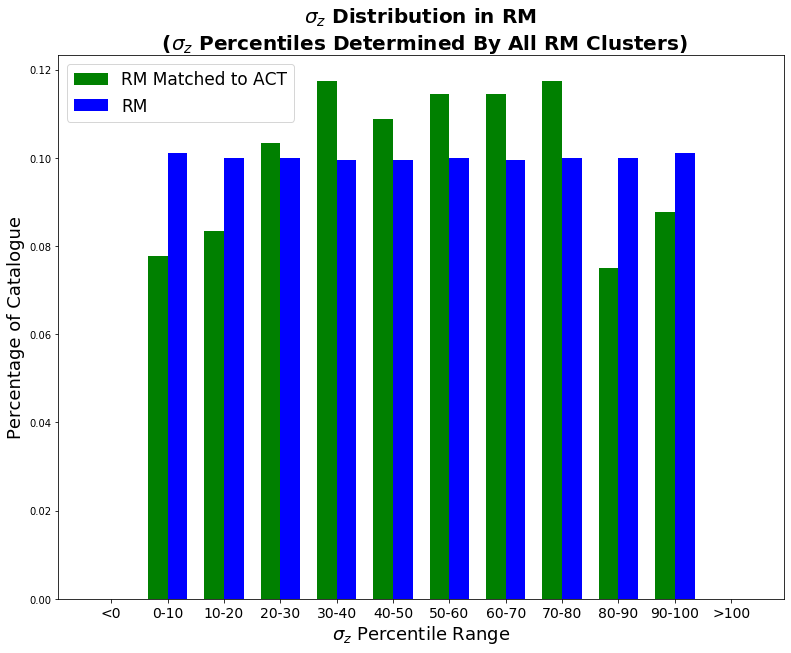

In [16]:
sigmaz_m_tiles_plot = sigmaz_m_tiles/sum(sigmaz_m_tiles)
sigmaz_r_tiles_plot = sigmaz_r_tiles/sum(sigmaz_r_tiles)

# Plot Histogram of Radii Distribution for both data sets
fig, ax = plt.subplots(figsize=(13,10))

x = np.arange(12)  # the label locations
width = 0.35  # the width of the bars

rects2 = ax.bar(x - width/2, sigmaz_m_tiles_plot, width, color = 'green', label='RM Matched to ACT')
rects2 = ax.bar(x + width/2, sigmaz_r_tiles_plot, width, color = 'blue', label='RM')
ax.set_ylabel('Percentage of Catalogue', fontsize = 18)
ax.set_xlabel('$\\sigma_z$ Percentile Range', fontsize = 18)

# Plot Characteristics
ax.set_title('$\\sigma_z$ Distribution in RM \n ($\\sigma_z$ Percentiles Determined By All RM Clusters)', 
             fontsize =20, fontweight=900.)
labels_x = ['<0', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']

ax.set_xticks(x)
ax.set_xticklabels(labels_x, size = 14)
ax.legend(fontsize = 17)

#plt.savefig('/Users/arielamsellem/Desktop/ACT_sigz_distribution_mass-match', dpi =600)

plt.show()